In [1]:
# -*- coding:utf-8 -*-
import sys
sys.path.append('../../')
%matplotlib inline
stdout = sys.stdout
import JSONData.tdx_data_Day as tdd
from ipykernel.iostream import OutStream
if isinstance(stdout,OutStream):
    sys.stdout = stdout
else:
    raise "no OutStream:%s"%(sys.stdout)
from  JSONData import sina_data 
import pandas as pd
# mpl.rcParams['font.sans-serif'] = ['STHeiti']
# mpl.rcParams['axes.unicode_minus'] = False
#中文字体显示  
import matplotlib.pyplot as plt
plt.ion()
plt.rc('font', family='SimHei', size=13)
from IPython.core.pylabtools import figsize
figsize(8, 5)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# df = tdd.get_tdx_Exp_day_to_df('999999',start=20170602,end=None).sort_index(ascending=True)
# dates = [i.replace('-','') for i in df.index.tolist()]
# prices = df.close.apply(lambda x:round(x,2)).tolist()

======笔形成最后一段未完成段判断是否是次级别的走势形成笔=======
次级别为:w
股票代码 002691
inx:va [13.04, 10.76, 12.08, 10.18, 13.68, 11.85, 12.5, 8.33, 9.77, 8.77, 9.61, 8.35, 8.65, 8.1, 9.48, 7.04, 8.11, 6.93, 7.23, 7.03, 9.1, 7.21] 161
chanK fenbi: [13.04, 9.88, 12.08, 9.58, 13.68, 10.88, 12.5, 7.69, 9.77, 7.98, 9.51, 8.02, 8.4, 7.85, 9.48, 6.46, 8.11, 6.7, 7.23, 6.83, 9.1, 6.87] 121
笔   : [4, 9, 11, 14, 18, 24, 28, 40, 42, 46, 48, 60, 62, 64, 70, 78, 93, 99, 101, 103, 105, 111] frsBiType: -1
图笔 : [6, 13, 15, 18, 24, 31, 36, 54, 57, 61, 64, 77, 80, 83, 89, 100, 122, 130, 132, 134, 139, 147] 线段 [18, 78, 105] [1, -1, 1]


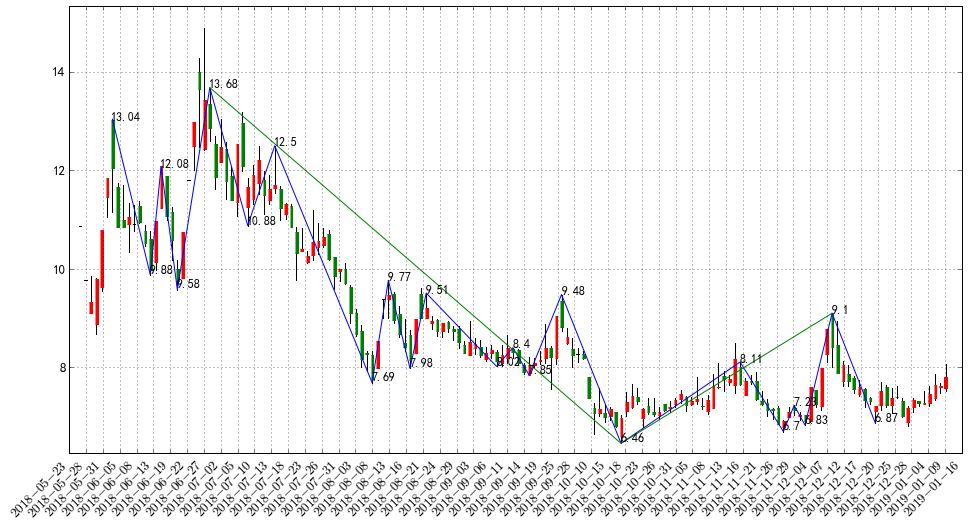

In [4]:
 # -*- coding:utf-8 -*-
# 缠论K线图展示完整版
import sys,logging
stdout=sys.stdout
sys.path.append('../../')
import JSONData.tdx_data_Day as tdd
# from JohnsonUtil import commonTips as cct
import my_chan2 as chan
import matplotlib as mat
import numpy as np
import datetime as dt
import datetime
import matplotlib.pyplot as plt
# bokeh.plotting
import time
from numpy import nan
from bokeh.models import ColumnDataSource, Rect, HoverTool, Range1d, LinearAxis, WheelZoomTool, PanTool, ResetTool, ResizeTool, PreviewSaveTool
# ================需要修改的参数==============
stock_code = '002691' # 股票代码
# start_date = '2017-01-01'
start_date = None
# end_date = '2017-10-01 15:00:00' # 最后生成k线日期
end_date = None
stock_days = 160 # 看几天/分钟前的k线
x_jizhun = 3 #window 周期 x轴展示的时间距离  5：日，40:30分钟， 48： 5分钟 
least_khl_num = 1
# stock_frequency = '5m' # 1d日线， 30m 30分钟， 5m 5分钟，1m 1分钟
stock_frequency = '1d' # 1d日线， 30m 30分钟， 5m 5分钟，1m 1分钟
chanK_flag = False# True 看缠论K线， False 看k线
show_mpl = True
# ============结束==================


'''
以下代码拷贝自https://www.joinquant.com/post/1756
感谢alpha-smart-dog
'''
# dt.datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")-dt.timedelta(days=5)
# quotes = get_price(stock_code, datetime.datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")-datetime.timedelta(days=stock_days) , end_date,\
#                    frequency=stock_frequency,skip_paused=False,fq='pre')
quotes = tdd.get_tdx_append_now_df_api(code=stock_code,start=start_date,end=end_date,dl=stock_days).sort_index(ascending=True)
quotes.index  = quotes.index.astype('datetime64')
quotes= quotes.loc[:,['open','close','high','low','vol','amount']]
# quotes = quotes.round(2)

# quotes.rename(columns={'amount': 'money'}, inplace=True)
# quotes.rename(columns={'vol': 'vol'}, inplace=True)
# print quotes[:2]
# 缠论k线
#         open  close   high    low    volume      money
# 2017-05-03  15.69  15.66  15.73  15.53  10557743  165075887
# 2017-05-04  15.66  15.63  15.70  15.52   8343270  130330396
# 2017-05-05  15.56  15.65  15.68  15.41  18384031  285966842
# 2017-05-08  15.62  15.75  15.76  15.54  12598891  197310688
quotes = chan.parse2ChanK(quotes, quotes.values) if chanK_flag else quotes
# print quotes[:4]

quotes[quotes['vol']==0]=np.nan
quotes= quotes.dropna()
Close=quotes['close']
Open=quotes['open']
High=quotes['high']
Low=quotes['low']
T0 = quotes.index.values
# T0 =  mdates.date2num(T0)
length=len(Close)


initial_trend = "down"
cur_ji = 1 if stock_frequency=='1d' else \
2 if stock_frequency=='30m' else \
3 if stock_frequency=='5m' else 4


print '======笔形成最后一段未完成段判断是否是次级别的走势形成笔======='
def con2Cxianduan(stock, k_data, chanK, frsBiType, biIdx, end_date, cur_ji = 1):
    max_k_num = 4
    if cur_ji>=4 or len(biIdx)==0: return biIdx
    idx = biIdx[len(biIdx)-1]
    k_data_dts = list(k_data.index)
    st_data = chanK['enddate'][idx]
    if st_data not in k_data_dts: return biIdx
    # 重构次级别线段的点到本级别的chanK中
    def refactorXd(biIdx, xdIdxc, chanK, chanKc, cur_ji):
        new_biIdx = []
        biIdxB = biIdx[len(biIdx)-1] if len(biIdx)>0 else 0
        for xdIdxcn in xdIdxc:
            for chanKidx in range(len(chanK.index))[biIdxB:]:
                if judge_day_bao(chanK, chanKidx, chanKc, xdIdxcn, cur_ji):
                    new_biIdx.append(chanKidx)
                    break
        return new_biIdx
    # 判断次级别日期是否被包含
    def judge_day_bao(chanK, chanKidx, chanKc, xdIdxcn, cur_ji):
        _end_date = chanK['enddate'][chanKidx]+datetime.timedelta(hours=15) if cur_ji==1 else chanK['enddate'][chanKidx]
        _start_date = chanK.index[chanKidx] if chanKidx==0\
        else chanK['enddate'][chanKidx-1]+datetime.timedelta(minutes=1)
#         print '连接包含日期', chanK.index[chanKidx], chanKc.index[xdIdxcn], chanK['enddate'][chanKidx]
        return _start_date<=chanKc.index[xdIdxcn]<=_end_date
    # cur_ji = 1 #当前级别
    #符合k线根数大于4根 1日级别， 2 30分钟， 3 5分钟， 4 一分钟

    if len(k_data_dts) - k_data_dts.index(st_data)>4:
        # frequency = '30m' if cur_ji+1==2 else '5m' if cur_ji+1==3 else '1m'
        frequency = 'w' if cur_ji+1==2 else '5m' if cur_ji+1==3 else '1m'
        print "次级别为:%s"%frequency
#         print chanK
        # k_data_c = get_price(stock, st_data, end_date, frequency=frequency)

        # k_data_c = tdd.get_tdx_stock_period_to_type(k_data, period_day=frequency,ncol=['vol','money'])
        k_data_c = tdd.get_tdx_stock_period_to_type(k_data, period_day=frequency,ncol=None)
        chanKc = chan.parse2ChanK(k_data_c, k_data_c.values)

        fenTypesc, fenIdxc = chan.parse2ChanFen(chanKc)
        if len(fenTypesc)==0: return biIdx
        biIdxc, frsBiTypec = chan.parse2ChanBi(fenTypesc, fenIdxc, chanKc,least_khl_num=least_khl_num)
        if len(biIdxc)==0: return biIdx
        xdIdxc, xdTypec = chan.parse2Xianduan(biIdxc, chanKc)
        biIdxc = con2Cxianduan(stock, k_data_c, chanKc, frsBiTypec, biIdxc, end_date, cur_ji+1)
        if len(xdIdxc)==0: return biIdx
#         print cur_ji, '次级别线段', xdIdxc, xdTypec
        #连接线段位为上级别的bi
        lastBiType = frsBiType if len(biIdx)%2==0 else -frsBiType
        if len(biIdx)==0:
            return refactorXd(biIdx, xdIdxc, chanK, chanKc, cur_ji)
        lastbi = biIdx.pop()
        firstbic = xdIdxc.pop(0)
#         print '最后一笔下和连段上',lastBiType, xdTypec
        # 同向连接
        if lastBiType == xdTypec:
            print '同向连接'
            biIdx = biIdx + refactorXd(biIdx, xdIdxc, chanK, chanKc, cur_ji)
        # 逆向连接
        else:
#             print '开始逆向连接'
#             print chanKc.index[firstbic],len(chanK.index), biIdx[len(biIdx)-1]
#             print lastBiType, chanK['low'][lastbi], chanKc['low'][firstbic], chanK['high'][lastbi],chanKc['high'][firstbic]
            _mid = [lastbi] if (lastBiType == -1 and chanK['low'][lastbi]<=chanKc['low'][firstbic])\
            or (lastBiType == 1 and chanK['high'][lastbi]>=chanKc['high'][firstbic]) else\
            [chanKidx for chanKidx in range(len(chanK.index))[biIdx[len(biIdx)-1]:]\
            if judge_day_bao(chanK, chanKidx, chanKc, firstbic, cur_ji)]
#             print '中间点', _mid
#             print '日期比较', '次级别', frequency
#             for chanKidx in range(len(chanK.index))[biIdx[len(biIdx)-1]:]:
#                 print chanK.index[chanKidx], chanKc.index[firstbic],\
#                 chanK['enddate'][chanKidx], chanK.index[chanKidx]<=chanKc.index[firstbic]<=(chanK['enddate'][chanKidx]\
#                 if cur_ji>1 else chanK['enddate'][chanKidx]+datetime.timedelta(hours=15))
            biIdx = biIdx + [_mid[0]] + refactorXd(biIdx, xdIdxc, chanK, chanKc, cur_ji)
#     print '最后'
    return biIdx


# ht = HoverTool(tooltips=[
#             ("date", "@date"),
#             ("open", "@open"),
#             ("close", "@close"),
#             ("high", "@high"),
#             ("low", "@low"),
#             ("volume", "@volume"),
#             ("money", "@money"),])
# TOOLS = [ht, WheelZoomTool(dimensions=['width']),\
#          ResizeTool(), ResetTool(),\
#          PanTool(dimensions=['width']), PreviewSaveTool()]

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid((10,4),(0,0),rowspan=10,colspan=4)
#fig = plt.figure()
#ax1 = plt.axes([0,0,3,2])

X=np.array(range(0, length))
pad_nan=X+nan

    #计算上 下影线
max_clop=Close.copy()
max_clop[Close<Open]=Open[Close<Open]
min_clop=Close.copy()
min_clop[Close>Open]=Open[Close>Open]

    #上影线
line_up=np.array([High,max_clop,pad_nan])
line_up=np.ravel(line_up,'F')
    #下影线
line_down=np.array([Low,min_clop,pad_nan])
line_down=np.ravel(line_down,'F')

    #计算上下影线对应的X坐标
pad_nan=nan+X
pad_X=np.array([X,X,X])
pad_X=np.ravel(pad_X,'F')

    #画出实体部分,先画收盘价在上的部分
up_cl=Close.copy()
up_cl[Close<=Open]=nan
up_op=Open.copy()
up_op[Close<=Open]=nan

down_cl=Close.copy()
down_cl[Open<=Close]=nan
down_op=Open.copy()
down_op[Open<=Close]=nan

even=Close.copy()
even[Close!=Open]=nan

#画出收红的实体部分
pad_box_up=np.array([up_op,up_op,up_cl,up_cl,pad_nan])
pad_box_up=np.ravel(pad_box_up,'F')
pad_box_down=np.array([down_cl,down_cl,down_op,down_op,pad_nan])
pad_box_down=np.ravel(pad_box_down,'F')
pad_box_even=np.array([even,even,even,even,pad_nan])
pad_box_even=np.ravel(pad_box_even,'F')

#X的nan可以不用与y一一对应
X_left=X-0.25
X_right=X+0.25
box_X=np.array([X_left,X_right,X_right,X_left,pad_nan])
# print box_X
box_X=np.ravel(box_X,'F')
# print box_X
#Close_handle=plt.plot(pad_X,line_up,color='k')

vertices_up=np.array([box_X,pad_box_up]).T
vertices_down=np.array([box_X,pad_box_down]).T
vertices_even=np.array([box_X,pad_box_even]).T

handle_box_up=mat.patches.Polygon(vertices_up,color='r',zorder=1)
handle_box_down=mat.patches.Polygon(vertices_down,color='g',zorder=1)
handle_box_even=mat.patches.Polygon(vertices_even,color='k',zorder=1)

ax1.add_patch(handle_box_up)
ax1.add_patch(handle_box_down)
ax1.add_patch(handle_box_even)

handle_line_up=mat.lines.Line2D(pad_X,line_up,color='k',linestyle='solid',zorder=0)
handle_line_down=mat.lines.Line2D(pad_X,line_down,color='k',linestyle='solid',zorder=0)

ax1.add_line(handle_line_up)
ax1.add_line(handle_line_down)

v=[0,length,Open.min()-0.5,Open.max()+0.5]
plt.axis(v)

# print  T0[-len(T0):].astype(dt.date)
T1 = T0[-len(T0):].astype(dt.date)/1000000000
# print T1
Ti=[]
for i in range(len(T0)/x_jizhun):
    a=i*x_jizhun
    d = dt.date.fromtimestamp(T1[a])
    # print d
    T2=d.strftime('$%Y-%m-%d$')
    Ti.append(T2)
    #print tab
d1= dt.date.fromtimestamp(T1[len(T0)-1])
d2=(d1+datetime.timedelta(days=1)).strftime('$%Y-%m-%d$')
Ti.append(d2)

ax1.set_xticks(np.linspace(-2,len(Close)+2,len(Ti)))

ll=Low.min()*0.97
hh=High.max()*1.03
ax1.set_ylim(ll,hh)

ax1.set_xticklabels(Ti)

plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

'''
以上代码拷贝自https://www.joinquant.com/post/1756
感谢alpha-smart-dog

K线图绘制完毕
'''
x_date_list = quotes.index.values.tolist()
# for x_date in x_date_list:
#     d = datetime.datetime.fromtimestamp(x_date/1000000000)
#     print d.strftime("%Y-%m-%d %H:%M:%S.%f")
# print x_date_list
k_data = quotes
k_values = k_data.values
# 缠论k线
chanK = quotes if chanK_flag else chan.parse2ChanK(k_data, k_values)
fenTypes, fenIdx = chan.parse2ChanFen(chanK)
# print "分型", fenTypes, fenIdx
biIdx, frsBiType = chan.parse2ChanBi(fenTypes, fenIdx, chanK,least_khl_num=least_khl_num)
# print "biIdx1:%s chanK:%s"%(biIdx,len(chanK))
biIdx = con2Cxianduan(stock_code, k_data, chanK, frsBiType, biIdx, end_date, cur_ji)
# print quotes['close'].apply(lambda x:round(x,2))

# print '股票代码', get_security_info(stock_code).display_name
print '股票代码', (stock_code)
#  3.得到分笔结果，计算坐标显示
x_fenbi_seq = []
y_fenbi_seq = []
for i in range(len(biIdx)):
    if biIdx[i]:
        fenType = -frsBiType if i%2==0 else frsBiType
#         dt = chanK['enddate'][biIdx[i]]
          # 缠论k线
        dt = chanK.index[biIdx[i]] if chanK_flag else chanK['enddate'][biIdx[i]]
#         print k_data['high'][dt], k_data['low'][dt]
        time_long = long(time.mktime((dt+datetime.timedelta(hours=8)).timetuple())*1000000000)
#         print x_date_list.index(time_long) if time_long in x_date_list else 0
        if fenType == 1:
            plt.text(x_date_list.index(time_long), k_data['high'][dt], \
                     str(k_data['high'][dt]), ha='left', fontsize=12)
            x_fenbi_seq.append(x_date_list.index(time_long))
            y_fenbi_seq.append(k_data['high'][dt])
        if fenType == -1:
            plt.text(x_date_list.index(time_long), k_data['low'][dt], \
                     str(k_data['low'][dt]), va='bottom', fontsize=12)
            x_fenbi_seq.append(x_date_list.index(time_long))
            y_fenbi_seq.append(k_data['low'][dt])
#             bottom_time = None
#             for k_line_dto in m_line_dto.member_list[::-1]:
#                 if k_line_dto.low == m_line_dto.low:
#                     # get_price返回的日期，默认时间是08:00:00
#                     bottom_time = k_line_dto.begin_time.strftime('%Y-%m-%d') +' 08:00:00'
#                     break
#             x_fenbi_seq.append(x_date_list.index(long(time.mktime(datetime.strptime(bottom_time, "%Y-%m-%d %H:%M:%S").timetuple())*1000000000)))
#             y_fenbi_seq.append(m_line_dto.low)

#  在原图基础上添加分笔蓝线
inx_value = chanK.high.values
inx_va  = [round(inx_value[x],2) for x in biIdx]
print "inx:va",inx_va,len(quotes.high)
print "chanK fenbi:",[round(y,2) for y in y_fenbi_seq],len(chanK)
print "笔   :", biIdx,"frsBiType:",frsBiType
print "图笔 :",x_fenbi_seq,
plt.plot(x_fenbi_seq,y_fenbi_seq)

#线段画到笔上
xdIdxs,xfenTypes = chan.parse2ChanXD(frsBiType,biIdx,chanK)
print '线段', xdIdxs,xfenTypes
x_xd_seq = []
y_xd_seq = []
for i in range(len(xdIdxs)):
    if xdIdxs[i]:
        fenType = xfenTypes[i]
#         dt = chanK['enddate'][biIdx[i]]
          # 缠论k线
        dt = chanK.index[xdIdxs[i]] if chanK_flag else chanK['enddate'][xdIdxs[i]]
#         print k_data['high'][dt], k_data['low'][dt]
        time_long = long(time.mktime((dt+datetime.timedelta(hours=8)).timetuple())*1000000000)
#         print x_date_list.index(time_long) if time_long in x_date_list else 0
        if fenType == 1:
            x_xd_seq.append(x_date_list.index(time_long))
            y_xd_seq.append(k_data['high'][dt])
        if fenType == -1:
            x_xd_seq.append(x_date_list.index(time_long))
            y_xd_seq.append(k_data['low'][dt])
#             bottom_time = None
#             for k_line_dto in m_line_dto.member_list[::-1]:
#                 if k_line_dto.low == m_line_dto.low:
#                     # get_price返回的日期，默认时间是08:00:00
#                     bottom_time = k_line_dto.begin_time.strftime('%Y-%m-%d') +' 08:00:00'
#                     break
#             x_fenbi_seq.append(x_date_list.index(long(time.mktime(datetime.strptime(bottom_time, "%Y-%m-%d %H:%M:%S").timetuple())*1000000000)))
#             y_fenbi_seq.append(m_line_dto.low)

#  在原图基础上添加分笔蓝线
plt.plot(x_xd_seq,y_xd_seq)

if show_mpl:
    plt.show()


#  在原图基础上添加分笔蓝线
# plt.plot(x_fenbi_seq,y_fenbi_seq)

# plt.show()


